In [65]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score , roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GINConv
from torch_geometric.nn import GatedGraphConv, Linear
from torch.nn import Linear, Sequential, ReLU
import torch.nn.functional as F
import random
import os


In our experimental setup, we observed that different GNN architectures exhibited varying AUC scores across multiple runs. This variability stemmed from the stochastic nature of neural network training, particularly random weight initialization. Since each model's weights were initialized from different random starting points, they would embark on distinct optimization trajectories through the loss landscape. Occasionally, a model would benefit from more favorable initial weights, leading to superior convergence and higher performance metrics. To ensure a fair and reproducible comparison between architectures, we fixed the random seed to 42 for all experiments. This guarantees that all models begin optimization from identical initial conditions, thereby isolating performance differences attributable to architectural design rather than random initialization effects.

In [66]:
SEED = 42
# Python built-in RNG
random.seed(SEED)
# NumPy RNG
np.random.seed(SEED)
# PyTorch RNG (CPU)
torch.manual_seed(SEED)
# PyTorch RNG (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# Ensure deterministic behavior in CUDA (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# enforce deterministic algorithms (PyTorch >= 1.8)
torch.use_deterministic_algorithms(True)
# Environment-level reproducibility
os.environ["PYTHONHASHSEED"] = str(SEED)

In [67]:
# protein-protein interactions of yeast
ppi_df = pd.read_csv("4932.protein.links.v12.0.csv")

# essential proteins of yeast (Gene essentiality was defined as genes that were either inviable upon deletion or annotated as essential in the YDP database.)
# Note: Due to the lack of a stable download option in the DEG database, essential gene labels were obtained from below Database .
labels_raw = pd.read_excel("pcbi.1008730.s008.xlsx",header=2)
gene_col = labels_raw.columns[0]

print(labels_raw.columns)

labels_raw["essentiality"] = (
    (labels_raw["inviable"] == 1) |
    (labels_raw["YDP essential"] == 1)
).astype(int)

labels_df = labels_raw[[gene_col, "essentiality"]]
labels_df.columns = ["protein_id", "essentiality"]
label_dict = dict(zip(labels_df["protein_id"], labels_df["essentiality"]))

print(labels_df.head())


Index(['Gene', 'Name', 'Gene description', 'Assigned class ', 'Unnamed: 4',
       'YDP essential', 'inviable', 'auxotroph', 'aerobic defective',
       'anaerobic defective', 'Comment', 'SGD Phenotype description'],
      dtype='object')
  protein_id  essentiality
0        NaN             0
1    YDL205C             1
2    YDR232W             1
3    YDR376W             1
4    YGL001C             1


In [68]:
ppi_df = ppi_df[ppi_df["combined_score"] >= 700] # consider high confidence interactions

ppi_df['protein1']=ppi_df['protein1'].str.split('.').str[1]  # in the PPI dataset proteins are determined with phrases like 4932.Q0010. we must eliminate 4932 and keep only the protein ID. these two lines do this.
ppi_df['protein2']=ppi_df['protein2'].str.split('.').str[1]

In [69]:
G = nx.Graph()
edges = list(zip(ppi_df["protein1"], ppi_df["protein2"]))
G.add_edges_from(edges)

G.remove_edges_from(nx.selfloop_edges(G)) # if you comment this line and run cells, you figure out that this dataset do not have self loop

print(f"PPI Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
# print(G.nodes())


# weighted graph for weighted pagerank ,...
weighted_G = nx.Graph()
for _, row in ppi_df.iterrows():
    weighted_G.add_edge(row['protein1'], row['protein2'], weight=row['combined_score']/1000)

PPI Graph: 5791 nodes, 104188 edges


In [70]:
# we only consider nodes of PPI network which we have their labels (we know their essentiality)
common_nodes = set(G.nodes()).intersection(label_dict.keys())
G = G.subgraph(common_nodes).copy()

print('We know labels of ',G.number_of_nodes(),' nodes.')
print('So we have ',G.number_of_edges(),' edges.')

We know labels of  887  nodes.
So we have  8356  edges.


In [71]:
G.remove_nodes_from(list(nx.isolates(G)))
print('Number of nodes after deleting isolated nodes is ',G.number_of_nodes()) # we do not have isolated nodes


Number of nodes after deleting isolated nodes is  857


In [72]:
print("Labeled graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

Labeled graph: 857 nodes, 8356 edges


In [73]:
y = np.array([label_dict[n] for n in G.nodes()])
print("Essential ratio:", y.mean())
print(y)


Essential ratio: 0.17269544924154026
[0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0
 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1
 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 

In [74]:
degree_feature = np.array([G.degree(n) for n in G.nodes()])

clust = nx.clustering(G)
clustering_coeff_feature = np.array([clust[n] for n in G.nodes()])

core = nx.core_number(G)
core_number_feature = np.array([core[n] for n in G.nodes()])

X = np.vstack([degree_feature, clustering_coeff_feature, core_number_feature]).T
X = StandardScaler().fit_transform(X)

node2id = {n: i for i, n in enumerate(G.nodes())}
id2node = {i: n for n, i in node2id.items()}

edge_index = []

for u, v in G.edges():
    edge_index.append([node2id[u], node2id[v]])
    edge_index.append([node2id[v], node2id[u]])

edge_index = np.array(edge_index).T


In [75]:
print("Final Dataset Summary")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("edge_index shape:", edge_index.shape)
print("Essential ratio:", y.mean())


Final Dataset Summary
X shape: (857, 3)
y shape: (857,)
edge_index shape: (2, 16712)
Essential ratio: 0.17269544924154026


In [76]:
# classical approachs of predicting essential proteins
centrality_scores = {
    "degree": nx.degree_centrality(G),
    "pagerank": nx.pagerank(G),
    "eigenvector": nx.eigenvector_centrality(G, max_iter=500),
    "closeness": nx.closeness_centrality(G),
    "betweenness": nx.betweenness_centrality(G, k=100, seed=42),
    "weighted pagerank": nx.pagerank(weighted_G, weight='weight')
}

cent_df = pd.DataFrame({
    name: [scores[n] for n in G.nodes()]
    for name, scores in centrality_scores.items()
})


cent_df["y"] = y



# random walk with restart
def build_transition_matrix(G, node2id):
    n = len(node2id)
    W = np.zeros((n, n))

    for u, v in G.edges():
        i, j = node2id[u], node2id[v]
        W[j, i] = 1
        W[i, j] = 1

    # column-normalize
    col_sum = W.sum(axis=0)
    col_sum[col_sum == 0] = 1
    W = W / col_sum

    return W


def random_walk_with_restart(G, node2id, restart_prob=0.3, max_iter=100, tol=1e-6):
    n = len(node2id)
    W = build_transition_matrix(G, node2id)

    # uniform start (unsupervised)
    p0 = np.ones(n) / n
    p = p0.copy()

    for _ in range(max_iter):
        p_new = (1 - restart_prob) * (W @ p) + restart_prob * p0
        if np.linalg.norm(p_new - p, 1) < tol:
            break
        p = p_new

    return p

# Random Walk with Restart was used as a classical graph-based baseline to capture both local and global topological importance. 
# The restart mechanism biases the random walk toward the starting distribution, preventing excessive diffusion and enabling the 
# identification of proteins located in dense and functionally relevant interaction neighborhoods.




In [77]:
def eval_classification(scores, y, thr=None):
    
    thr_computing_approach=thr

    if thr == 'top_percentile':
        thr = np.percentile(scores, 100 * (1 - y.mean())) # Top Percentile approach of computing threshold

    elif thr == 'Youden\'s J':    # Youden's J Statistic (ROC-based) approach of computing threshold
        fpr, tpr, thresholds = roc_curve(y, scores)
        youden_idx = np.argmax(tpr - fpr)
        thr = thresholds[youden_idx]

    elif thr == 'f1_maximization':   # F1-Score Maximization (Precision-Recall based) approach of computing threshold
        precisions, recalls, thresholds = precision_recall_curve(y, scores)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        optimal_idx = np.argmax(f1_scores)
        thr = thresholds[optimal_idx]


    y_pred = (scores >= thr).astype(int) # if score is bigger than thr consider protein as essential
    return {
        "AUC": roc_auc_score(y, scores),
        "F1": f1_score(y, y_pred),
        "Threshold computing approach": thr_computing_approach
    }

for c in centrality_scores:
    res = eval_classification(cent_df[c].values, y,'top_percentile')
    print(c, res,)

    res = eval_classification(cent_df[c].values, y,'Youden\'s J')
    print(c, res,)

    res = eval_classification(cent_df[c].values, y,'f1_maximization')
    print(c, res,'\n')

    


# RWR evaluation
rwr_scores = random_walk_with_restart(G, node2id, restart_prob=0.3)
res = eval_classification(rwr_scores, y,'top_percentile')
print('RWR', res,)

res = eval_classification(rwr_scores, y,'Youden\'s J')
print('RWR', res,)

res = eval_classification(rwr_scores, y,'f1_maximization')
print('RWR', res,)
    
print()


def precision_at_k(scores, y, k=100):     # this metric determines that if we are only allowed to propose K genes/proteins as essential, what percentage of them are actually essential?
    idx = np.argsort(scores)[::-1][:k]    # Precision@100 was used to evaluate the ranking quality of each method, measuring the fraction of truly essential proteins among the top 100 highest-scoring candidates.
    return y[idx].sum() / k

for c in centrality_scores:
    p_at_k = precision_at_k(cent_df[c].values, y, k=100)
    print(f"{c} Precision@100:", p_at_k)


p100 = precision_at_k(rwr_scores, y, k=100)
print("RWR Precision@100:", p100)


# Note: We evaluated all methods using both classification and ranking metrics. Classification performance was
#  measured using AUC-ROC and F1-score on a held-out test set. Ranking quality was assessed using Precision@100,
#  reflecting the practical scenario of prioritizing a limited number of candidate essential proteins.

degree {'AUC': 0.5622879579156025, 'F1': 0.18241042345276873, 'Threshold computing approach': 'top_percentile'}
degree {'AUC': 0.5622879579156025, 'F1': 0.324766355140187, 'Threshold computing approach': "Youden's J"}
degree {'AUC': 0.5622879579156025, 'F1': 0.0, 'Threshold computing approach': 'f1_maximization'} 

pagerank {'AUC': 0.5842116799451074, 'F1': 0.19594594594594594, 'Threshold computing approach': 'top_percentile'}
pagerank {'AUC': 0.5842116799451074, 'F1': 0.3233743409490334, 'Threshold computing approach': "Youden's J"}
pagerank {'AUC': 0.5842116799451074, 'F1': 0.0, 'Threshold computing approach': 'f1_maximization'} 

eigenvector {'AUC': 0.47409751076887896, 'F1': 0.11486486486486487, 'Threshold computing approach': 'top_percentile'}
eigenvector {'AUC': 0.47409751076887896, 'F1': 0.28482003129890454, 'Threshold computing approach': "Youden's J"}
eigenvector {'AUC': 0.47409751076887896, 'F1': 0.0, 'Threshold computing approach': 'f1_maximization'} 

closeness {'AUC': 0.51

/tmp/ipykernel_26926/3063793715.py:15: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
/tmp/ipykernel_26926/3063793715.py:15: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
/tmp/ipykernel_26926/3063793715.py:15: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
/tmp/ipykernel_26926/3063793715.py:15: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
/tmp/ipykernel_26926/3063793715.py:15: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
/tmp/ipykernel_26926/3063793715.py:15: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
/tmp/ipykernel_26926/3063793715.py:15: RuntimeWarning: inv

### **Threshold Optimization Methods**

#### **1. Top Percentile Method (Current Implementation)**
This approach determines the classification threshold by selecting scores at the (100 × (1 - essential_ratio))-th percentile. The method operates under the assumption that the proportion of essential proteins in the test set is known or can be reliably estimated.

**Formula:**  
Threshold = Percentile(scores, 100 × (1 - essential_ratio))

Where `essential_ratio` represents the actual proportion of essential proteins in the dataset (e.g., 0.1727 in our study).

**Rationale:**  
- If the essentiality ratio is `p`, we expect approximately `p × N` proteins to be essential
- By selecting the top `(1-p) × 100` percentile of scores, we classify the highest-scoring `p × N` proteins as essential
- This creates a balanced classification scenario where the predicted positive class size matches the actual positive class size

**Advantages:**  
- Simple and computationally efficient  
- Maintains consistency between predicted and actual class distributions  
- Useful for comparative studies where consistent positive class sizes are desired

**Limitations:**  
- Assumes the essentiality ratio is known or can be accurately estimated  
- May not optimize classification performance metrics (e.g., F1-score, accuracy)  
- Does not account for the actual score distribution or separation between classes

---

#### **2. Youden's J Statistic (ROC-based)**
The Youden's J statistic identifies the optimal classification threshold by maximizing the difference between True Positive Rate (TPR) and False Positive Rate (FPR). This approach finds the point on the ROC curve that provides the best balance between sensitivity (ability to detect true essentials) and specificity (ability to exclude non-essentials).

**Formula:**  
J = TPR - FPR = Sensitivity + Specificity - 1

**Implementation logic:**  
We compute ROC curve metrics across all possible thresholds and select the threshold where (TPR - FPR) is maximized.

---

#### **3. F1-Score Maximization (Precision-Recall based)**
For imbalanced datasets (where essential proteins represent only ~17% of instances), F1-score maximization provides a more appropriate threshold selection method. The F1-score is the harmonic mean of precision and recall, balancing the trade-off between these two crucial metrics.

**Formula:**  
F1 = 2 × (Precision × Recall) / (Precision + Recall)

**Implementation logic:**  
We compute precision-recall metrics across threshold values and select the threshold that maximizes the F1-score, ensuring optimal balance between correctly identifying essentials (recall) and minimizing false positives (precision).

---

#### **4. Precision@k Evaluation (Ranking-based)**
Unlike threshold-based classification methods, Precision@k evaluates the proportion of truly essential proteins among the top k highest-scoring candidates, without requiring explicit threshold determination.

**Relation to Percentile Method:**  
While the percentile method uses a percentage of the dataset (e.g., top 17.27%), Precision@k evaluates a fixed number of top-ranked predictions (e.g., top 100 proteins). This distinction is particularly important for practical applications where experimental validation resources are limited to a specific number of candidates.

**Practical significance:**  
In biological research settings, scientists often have capacity to experimentally validate only a limited number of candidate essential proteins. Therefore, Precision@k metrics (especially for small k values like 10, 20, or 50) better reflect real-world experimental constraints compared to classification metrics that assume validation of all predictions above a certain threshold.

---
---

#### What is AUC-ROC?
AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is a comprehensive evaluation metric that measures the overall ranking performance of a classification model across all possible threshold values. The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The AUC value ranges from 0 to 1, where 0.5 indicates random guessing and 1 represents perfect separation between positive and negative classes.

#### **Observed Phenomenon: Trade-off between AUC and Precision@k**
In our experiments, we observed a trade-off when comparing unweighted and weighted PageRank algorithms for essential protein prediction. While weighted PageRank demonstrated slightly lower AUC-ROC (approximately 0.02 decrease) compared to its unweighted counterpart, it showed improved Precision@100 performance.

#### Scientific Explanation
This observed discrepancy stems from the fundamental difference in what these metrics evaluate and how edge weighting alters score distributions:

+ AUC Sensitivity to Full Score Distribution:

AUC evaluates performance across all possible classification thresholds

Weighted PageRank, by incorporating interaction confidence scores (combined_score), redistributes node importance across the entire network

This redistribution may slightly disrupt the optimal linear separability between essential and non-essential proteins across all thresholds, leading to minor AUC reduction

+ Precision@k Focus on Top-Ranked Candidates:

Precision@k specifically evaluates the accuracy among the top k highest-scoring candidates

Weighted PageRank enhances the ranking of proteins involved in high-confidence interactions

Since essential proteins tend to participate in reliable, biologically significant interactions, they receive proportionally higher scores in the weighted version

Consequently, more truly essential proteins appear in the top 100 rankings, improving Precision@100

+ Biological Justification:

Protein-protein interaction databases like STRING provide confidence scores reflecting experimental and computational evidence reliability

Weighted PageRank prioritizes proteins within highly-confirmed interaction subnetworks

Essential proteins often reside in such well-characterized, functionally critical modules

Therefore, weighting emphasizes biologically relevant network regions, benefiting top-k precision despite potential AUC trade-offs


In [78]:
# GNNs

# data preparation 
data = Data(
    x=torch.tensor(X, dtype=torch.float),
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    y=torch.tensor(y, dtype=torch.long)
)

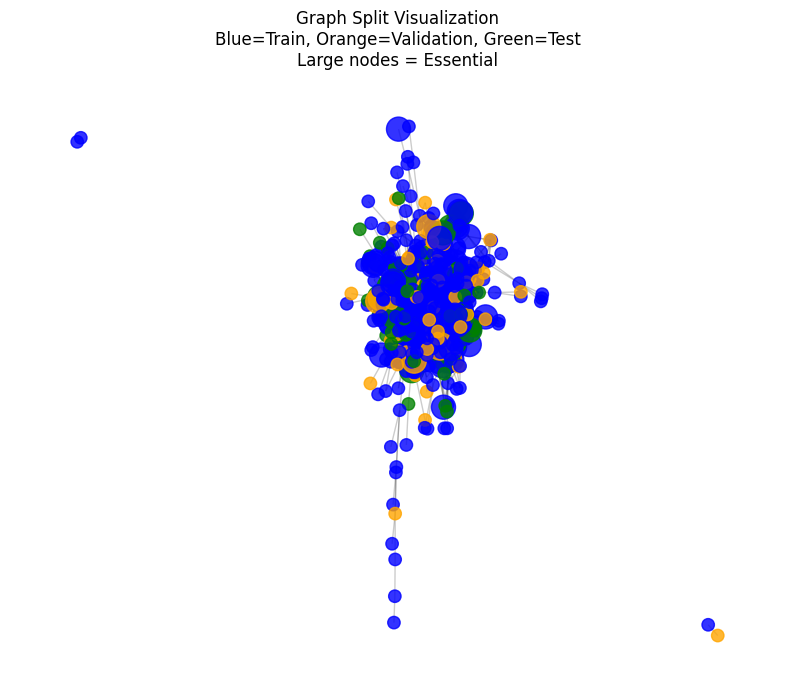

In [79]:
# split data to the train-validation-test sets

idx = np.arange(len(y))

train_idx, test_idx = train_test_split(
    idx, test_size=0.15, stratify=y, random_state=42  # stratified sampling causes the ratio of classes (essential / non-essential) in train and test be approximately equal to the ratio of the entire dataset.
)

train_idx, val_idx = train_test_split(
    train_idx, test_size=0.176, stratify=y[train_idx], random_state=42
)
# Training, validation, and test nodes were specified using boolean masks over a single graph, following the standard practice in node classification with graph neural networks.
def make_mask(idx, n):
    m = torch.zeros(n, dtype=torch.bool)
    m[idx] = True
    return m

data.train_mask = make_mask(train_idx, len(y))
data.val_mask   = make_mask(val_idx, len(y))
data.test_mask  = make_mask(test_idx, len(y))


# Due to strong dependencies between nodes in the PPI network, standard k-fold cross-validation can introduce information leakage. 
# Therefore, if we want we can use stratified random splits and report average performance over multiple runs. (in graphs we can use Subgraph CV or Repeated random split instead of K-fold CV)


pos = nx.spring_layout(G, seed=42)

node_colors = []
node_shapes = []

for i in range(len(data.y)):
    if data.train_mask[i]:
        node_colors.append("blue")
    elif data.val_mask[i]:
        node_colors.append("orange")
    else:
        node_colors.append("green")

# essential vs non-essential overlay
sizes = np.where(data.y.cpu().numpy() == 1, 300, 80)

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=sizes,
    alpha=0.8
)

plt.title(
    "Graph Split Visualization\n"
    "Blue=Train, Orange=Validation, Green=Test\n"
    "Large nodes = Essential"
)
plt.axis("off")
plt.show()

In [80]:
# GCN

class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        self.c1 = GCNConv(in_dim, hid)
        self.c2 = GCNConv(hid, hid)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.c1(x, edge_index))
        x = F.relu(self.c2(x, edge_index))
        return self.out(x).view(-1)



In [81]:
# GraphSAGE

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        self.c1 = SAGEConv(in_dim, hid)
        self.c2 = SAGEConv(hid, hid)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.c1(x, edge_index))
        x = F.relu(self.c2(x, edge_index))
        return self.out(x).view(-1)

In [82]:
# GATv2

class GATv2(torch.nn.Module):
    def __init__(self, in_dim, hid=64, heads=4):
        super().__init__()
        self.c1 = GATv2Conv(in_dim, hid, heads=heads)
        self.c2 = GATv2Conv(hid * heads, hid, heads=1)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index):
        x = F.elu(self.c1(x, edge_index))
        x = F.elu(self.c2(x, edge_index))
        return self.out(x).view(-1)


In [83]:
# GIN

class GIN(torch.nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        nn1 = torch.nn.Sequential(Linear(in_dim, hid), torch.nn.ReLU())
        nn2 = torch.nn.Sequential(Linear(hid, hid), torch.nn.ReLU())
        self.c1 = GINConv(nn1)
        self.c2 = GINConv(nn2)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index):
        x = self.c1(x, edge_index)
        x = self.c2(x, edge_index)
        return self.out(x).view(-1)


In [84]:
# GatedGCN

class GatedGCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim=64, num_layers=3):
        super().__init__()

        self.input_proj = Linear(in_dim, hid_dim)

        self.gated_conv = GatedGraphConv(
            out_channels=hid_dim,
            num_layers=num_layers
        )

        self.output_proj = Linear(hid_dim, 1)

    def forward(self, x, edge_index):
        x = self.input_proj(x)
        x = self.gated_conv(x, edge_index)
        return self.output_proj(x).view(-1)

In [85]:
# All GNN architectures were intentionally kept shallow to ensure fair comparison with classical graph-based methods and to 
# mitigate overfitting and oversmoothing effects in the relatively small and dense PPI network.

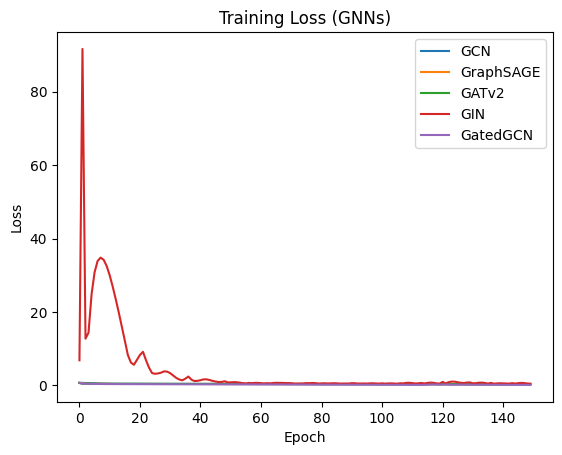

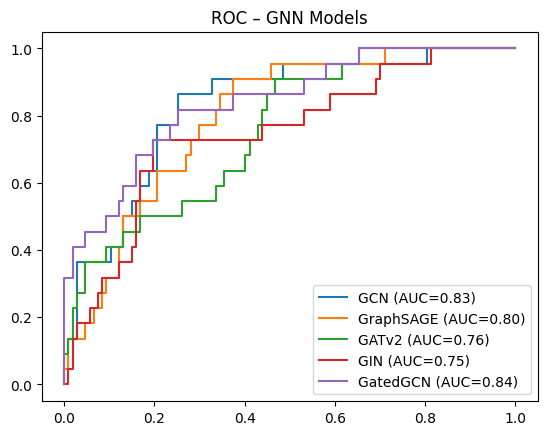

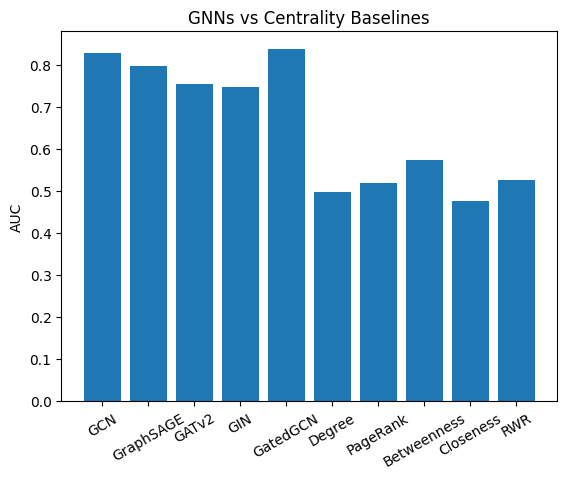

In [86]:
# GNNs train & evaluation
def train_model(model, data, epochs=150):
    opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    losses = []

    for _ in range(epochs):
        model.train()
        opt.zero_grad()
        logits = model(data.x, data.edge_index)
        loss = F.binary_cross_entropy_with_logits(
            logits[data.train_mask],
            data.y[data.train_mask].float()
        )
        loss.backward()
        opt.step()
        losses.append(loss.item())

    return losses



@torch.no_grad()
def evaluate_model(model, data):
    model.eval()
    scores = torch.sigmoid(model(data.x, data.edge_index)).cpu().numpy()
    y_true = data.y.cpu().numpy()

    return {
        "scores": scores,
        "auc": roc_auc_score(y_true[data.test_mask], scores[data.test_mask]),
        "f1": f1_score(y_true[data.test_mask], scores[data.test_mask] > 0.5)
    }



models = {
    "GCN": GCN(data.x.shape[1]),
    "GraphSAGE": GraphSAGE(data.x.shape[1]),
    "GATv2": GATv2(data.x.shape[1]),
    "GIN": GIN(data.x.shape[1]),
    "GatedGCN": GatedGCN(data.x.shape[1])
}

results, loss_curves = {}, {}

for name, model in models.items():
    loss_curves[name] = train_model(model, data)
    results[name] = evaluate_model(model, data)



centrality_scores = {
    "Degree": np.array(list(nx.degree_centrality(G).values())),
    "PageRank": np.array(list(nx.pagerank(G).values())),
    "Betweenness": np.array(list(nx.betweenness_centrality(G).values())),
    "Closeness": np.array(list(nx.closeness_centrality(G).values())),
    "RWR": rwr_scores
}


centrality_auc = {
    k: roc_auc_score(data.y[data.test_mask], v[data.test_mask])
    for k, v in centrality_scores.items()
}




# plot of training loss
plt.figure()
for k, v in loss_curves.items():
    plt.plot(v, label=k)
plt.title("Training Loss (GNNs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# plot of ROC curves (GNNs)
plt.figure()
for k, r in results.items():
    fpr, tpr, _ = roc_curve(
        data.y[data.test_mask], r["scores"][data.test_mask]
    )
    plt.plot(fpr, tpr, label=f"{k} (AUC={r['auc']:.2f})")
plt.title("ROC – GNN Models")
plt.legend()
plt.show()

# Combine GNN and centrality AUCs
all_methods_auc = {}

# Add GNN models
for name, res in results.items():
    all_methods_auc[name] = res["auc"]
# Add weighted centrality baselines
all_methods_auc.update(centrality_auc)

# plot of GNN vs Centrality (AUC)
names = list(results.keys()) + list(centrality_auc.keys())
auc_vals = [results[m]["auc"] for m in results] + list(centrality_auc.values()) 

plt.figure()
plt.bar(names, auc_vals)
plt.xticks(rotation=30)
plt.ylabel("AUC")
plt.title("GNNs vs Centrality Baselines")
plt.show()

### Using Weighted Graph 

In this study, we explicitly incorporate **edge confidence scores** from the STRING PPI network by constructing a **weighted graph**, where edge weights are derived from the normalized "combined_score". This allows message-passing models to account not only for network topology but also for **interaction reliability**.

#### Graph Construction Recap

* Nodes represent proteins with known essentiality labels.
* Edges represent protein–protein interactions with "combined_score ≥ 700".
* Edge weights are defined as:


         w(i,j) = combined_score(i,j)/1000


* Isolated nodes are removed to ensure all nodes participate in message passing.

The final weighted graph contains:

* **Nodes**: labeled proteins only
* **Edges**: high-confidence PPIs with continuous weights in (0.7, 1.0)


### Feature Design Strategy

To ensure **fair comparison across models**, we adopt a hybrid design:

* **Node features (X)**
  Derived from **unweighted structural topology**, which is common practice to avoid biasing handcrafted features toward edge confidence:

  * Degree centrality
  * Clustering coefficient
  * k-core number
    These features are standardized using "StandardScaler".

* **Edge weights**
  Used **only during message passing** in weighted GNN models.

This separation ensures that performance gains stem from **learned weighted aggregation**, not from engineered features.


In [87]:
ppi_df = pd.read_csv("4932.protein.links.v12.0.csv")
labels_raw = pd.read_excel("pcbi.1008730.s008.xlsx", header=2)
gene_col = labels_raw.columns[0]

labels_raw["essentiality"] = ((labels_raw["inviable"] == 1) | (labels_raw["YDP essential"] == 1)).astype(int)
labels_df = labels_raw[[gene_col, "essentiality"]].copy()
labels_df.columns = ["protein_id", "essentiality"]
label_dict = dict(zip(labels_df["protein_id"], labels_df["essentiality"]))

In [88]:
#  Build Weighted Graph Only
ppi_high = ppi_df[ppi_df["combined_score"] >= 700].copy()
ppi_high['protein1'] = ppi_high['protein1'].str.split('.').str[1]
ppi_high['protein2'] = ppi_high['protein2'].str.split('.').str[1]
ppi_high["weight"] = ppi_high["combined_score"] / 1000.0 

G_w = nx.Graph()
for _, row in ppi_high.iterrows():
    G_w.add_edge(row["protein1"], row["protein2"], weight=row["weight"])

# Keep only labeled nodes
common_nodes = set(G_w.nodes()).intersection(label_dict.keys())
G_w = G_w.subgraph(common_nodes).copy()
G_w.remove_nodes_from(list(nx.isolates(G_w)))

print(f"Weighted Graph: {G_w.number_of_nodes()} nodes, {G_w.number_of_edges()} edges")

# Labels and features (using unweighted topology for features — standard practice)
node_list = list(G_w.nodes())
y = np.array([label_dict[n] for n in node_list])

# Structural features (unweighted for fairness, as is common)
degree_f = np.array([G_w.degree(n) for n in node_list])  # degree is count, not weighted
clust_f = np.array([nx.clustering(G_w)[n] for n in node_list])
core_f = np.array([nx.core_number(G_w)[n] for n in node_list])

X = StandardScaler().fit_transform(np.vstack([degree_f, clust_f, core_f]).T)

node2id = {n: i for i, n in enumerate(node_list)}


Weighted Graph: 857 nodes, 8356 edges


In [89]:

# Data Splits
idx = np.arange(len(y))
train_idx, test_idx = train_test_split(idx, test_size=0.15, stratify=y, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.176, stratify=y[train_idx], random_state=42)

def make_mask(idx, n):
    mask = torch.zeros(n, dtype=torch.bool)
    mask[idx] = True
    return mask

train_mask = make_mask(train_idx, len(y))
val_mask   = make_mask(val_idx, len(y))
test_mask  = make_mask(test_idx, len(y))


In [90]:

edges_w = [[node2id[u], node2id[v], d['weight']] for u, v, d in G_w.edges(data=True)]
edge_index = torch.tensor([[e[0], e[1]] for e in edges_w], dtype=torch.long).t().contiguous()
edge_weight = torch.tensor([e[2] for e in edges_w], dtype=torch.float)

# Make undirected
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
edge_weight = torch.cat([edge_weight, edge_weight])

data = Data(
    x=torch.tensor(X, dtype=torch.float),
    edge_index=edge_index,
    edge_weight=edge_weight,
    y=torch.tensor(y, dtype=torch.long),
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)


## Weighted Graph Neural Network Models


### 1. Weighted Graph Convolutional Network (GCN_w)

**Why chosen**

GCN_w serves as a **baseline weighted message-passing model**. The "GCNConv" layer directly supports edge weights, allowing interaction confidence to scale neighborhood aggregation without architectural modification.

**Expected result**

* Consistent improvement over unweighted GCN
* Robust but limited expressiveness
* Serves as a lower bound for weighted GNN performance


### 2. Weighted Graph Isomorphism Network (GIN_w via GINEConv)

**Why chosen**

Standard GIN is among the most expressive GNNs but lacks edge awareness. By using "GINEConv", we extend GIN to explicitly incorporate edge weights as continuous edge attributes.

**Expected result**

* Improved detection of essential proteins with distinctive neighborhoods
* Higher ROC–AUC than GCN_w
* Particularly effective for sparse but reliable interaction subgraphs


### 3. Weighted Gated Graph Convolutional Network (GatedGCN_w)

**Why chosen**

GatedGCN introduces **recurrent message passing with gating mechanisms**, enabling dynamic control over information flow across multiple propagation steps.

**Expected result**

* Strong performance in dense or multi-hop interaction regions
* Superior modeling of complex biological dependencies
* Competitive or best overall ROC–AUC among tested models



In [91]:

from torch_geometric.nn import GCNConv, GINEConv, GatedGraphConv
from sklearn.metrics import roc_auc_score


# GCN supports edge_weight natively
class GCN_w(torch.nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        self.c1 = GCNConv(in_dim, hid)
        self.c2 = GCNConv(hid, hid)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.c1(x, edge_index, edge_weight))
        x = F.relu(self.c2(x, edge_index, edge_weight))
        return self.out(x).view(-1)

# Weighted GIN (via GINEConv)
class GIN_w(torch.nn.Module):
    def __init__(self, in_dim, hid=64):
        super().__init__()
        nn1 = torch.nn.Sequential(Linear(in_dim, hid), torch.nn.ReLU(), Linear(hid, hid))
        nn2 = torch.nn.Sequential(Linear(hid, hid), torch.nn.ReLU(), Linear(hid, hid))
        self.c1 = GINEConv(nn1, edge_dim=1)
        self.c2 = GINEConv(nn2, edge_dim=1)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index, edge_weight=None):
        if edge_weight is None:
            edge_weight = torch.ones(edge_index.size(1), device=x.device)
        edge_attr = edge_weight.unsqueeze(-1)
        x = self.c1(x, edge_index, edge_attr)
        x = self.c2(x, edge_index, edge_attr)
        return self.out(x).view(-1)

# Weighted GatedGCN
class GatedGCN_w(torch.nn.Module):
    def __init__(self, in_dim, hid=64, num_layers=3):
        super().__init__()
        self.input_proj = Linear(in_dim, hid)
        self.gated = GatedGraphConv(out_channels=hid, num_layers=num_layers)
        self.out = Linear(hid, 1)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.relu(self.input_proj(x))
        x = self.gated(x, edge_index, edge_weight)
        return self.out(x).view(-1)



In [92]:
def train_and_evaluate(model_cls, data, name, epochs=150):
    model = model_cls(data.x.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(data.x, data.edge_index, data.edge_weight)
        loss = F.binary_cross_entropy_with_logits(
            logits[data.train_mask], 
            data.y[data.train_mask].float()
        )
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        scores = torch.sigmoid(model(data.x, data.edge_index, data.edge_weight)).cpu().numpy()

    auc = roc_auc_score(
        data.y[data.test_mask].cpu().numpy(), 
        scores[data.test_mask]
    )

    return {"losses": losses, "scores": scores, "auc": auc}

models_list = [GCN_w, GIN_w, GatedGCN_w]

loss_curves = {}
results = {}

print("Training weighted GNN models...")
for cls in models_list:
    name = cls.__name__
    print(f"  → {name}")
    res = train_and_evaluate(cls, data, name)
    loss_curves[name] = res["losses"]
    results[name] = {"scores": res["scores"], "auc": res["auc"]}

print("Training complete!")

Training weighted GNN models...
  → GCN_w
  → GIN_w
  → GatedGCN_w
Training complete!



## Weighted Network Centrality–Based Methods

### 1. Weighted Degree Centrality (Degree_w)

**Definition**
The weighted degree of a node is the sum of confidence scores of its interactions.

**What it captures**

* Local interaction strength
* Proteins with many high-confidence partners

**Expected behavior**

* Simple but strong baseline
* Good recall for hub-like essential proteins
* Limited discrimination beyond immediate neighbors

### 2. Weighted PageRank (PageRank_w)

**Definition**
PageRank models a random walker that preferentially follows high-confidence interactions.

**What it captures**

* Global influence in the interaction network
* Importance derived from other important proteins

**Expected behavior**

* More robust than degree centrality
* Performs well in dense, interconnected regions
* Still limited by fixed propagation dynamics


### 3. Weighted Closeness Centrality (Closeness_w)

**Definition**
Closeness is computed using **inverse edge weights as distances**, so high-confidence edges correspond to shorter paths.

**What it captures**

* How efficiently a protein can influence the entire network
* Emphasis on reliable interaction pathways

**Expected behavior**

* Moderate performance
* Sensitive to graph connectivity
* Less effective in large or modular networks


### 4. Weighted Betweenness Centrality (Betweenness_w)

**Definition**
Betweenness measures how often a node lies on shortest paths, weighted by interaction confidence. To reduce computational cost, it is approximated using node sampling.

**What it captures**

* Proteins acting as communication bridges
* Control over information flow between modules

**Expected behavior**

* High precision for specific bottleneck proteins
* Lower overall AUC due to sparsity
* Computationally expensive compared to other measures


## Weighted Random Walk with Restart (RWR_w)

### Method Description

Random Walk with Restart simulates a stochastic diffusion process over the weighted PPI network. At each step:

* With probability (1 - r), the walker follows weighted edges
* With probability (r), it restarts uniformly across nodes

This yields a **steady-state probability distribution** reflecting long-term visitation frequency.

**What it captures**

* Global topological relevance
* Accumulated influence through multi-hop high-confidence interactions

**Expected behavior**

* Strongest classical baseline
* Smooths local noise via diffusion
* Still limited by absence of label supervision


In [93]:

centrality_scores = {
    "Degree_w": np.array([G_w.degree(n, weight='weight') for n in node_list]),
    "PageRank_w": np.array(list(nx.pagerank(G_w, weight='weight').values())),
    "Closeness_w": np.array(list(nx.closeness_centrality(G_w, distance=lambda u,v,d: 1/d['weight']).values())),
    "Betweenness_w": np.array(list(nx.betweenness_centrality(G_w, weight='weight', k=100, seed=42).values())),
}

# Weighted RWR
def weighted_rwr(G, restart_prob=0.3, max_iter=100):
    n = G.number_of_nodes()
    node_idx = {node: i for i, node in enumerate(node_list)}
    W = np.zeros((n, n))
    for u, v, d in G.edges(data=True):
        i, j = node_idx[u], node_idx[v]
        w = d['weight']
        W[i, j] = w
        W[j, i] = w
    col_sum = W.sum(axis=0)
    col_sum[col_sum == 0] = 1
    W = W / col_sum
    p = np.ones(n) / n
    for _ in range(max_iter):
        p_new = (1 - restart_prob) * W @ p + restart_prob * np.ones(n) / n
        if np.linalg.norm(p_new - p) < 1e-6: break
        p = p_new
    return p

centrality_scores["RWR_w"] = weighted_rwr(G_w)
centrality_auc = {k: roc_auc_score(y[test_mask], v[test_mask]) for k, v in centrality_scores.items()}


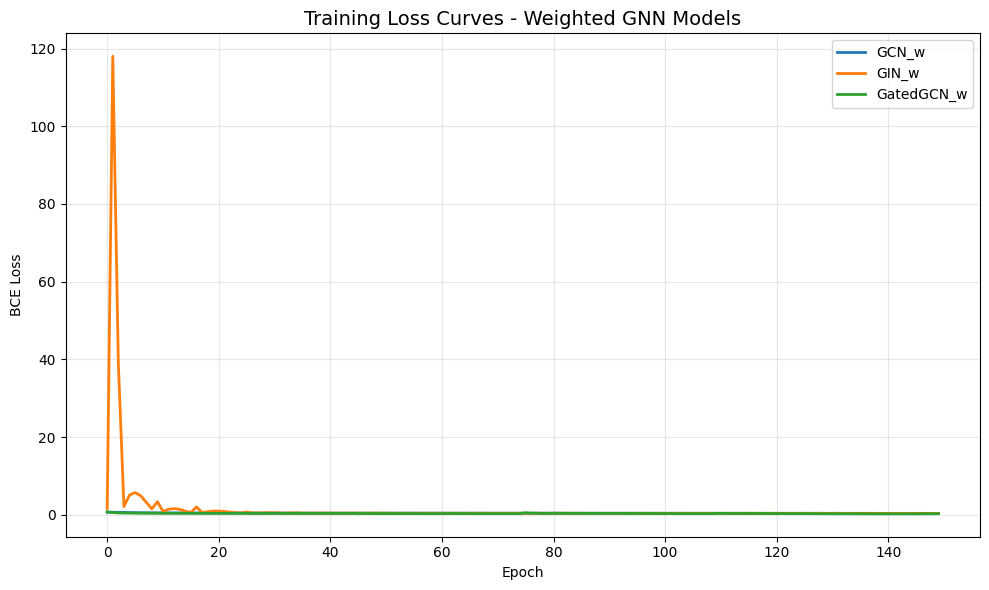

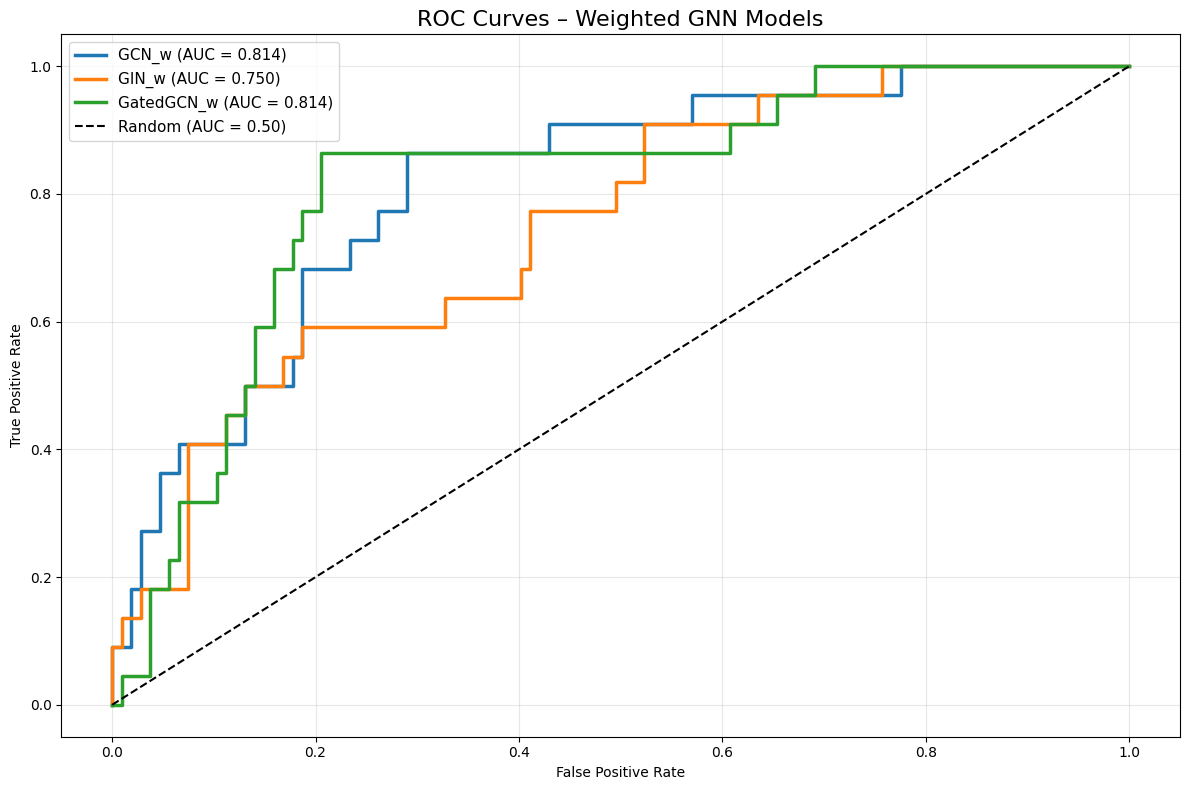

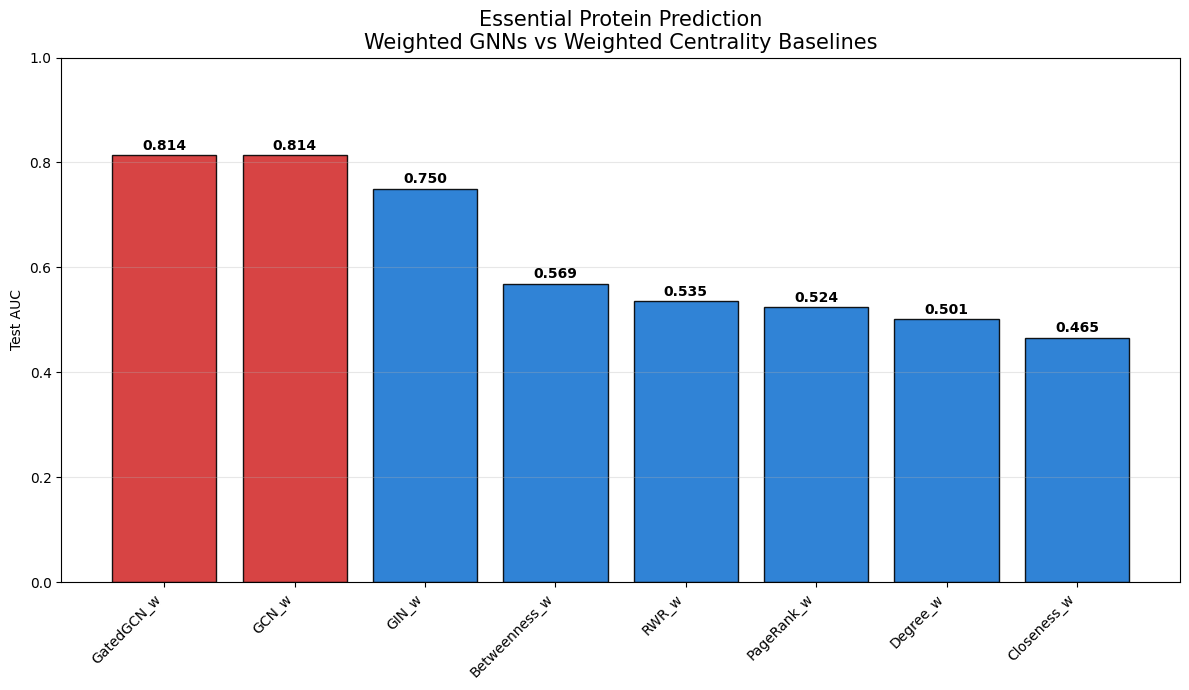

In [94]:

plt.figure(figsize=(10, 6))
for name, losses in loss_curves.items():
    plt.plot(losses, label=name, linewidth=2)
plt.title("Training Loss Curves - Weighted GNN Models", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
test_idx_np = test_mask.cpu().numpy()
y_test = y[test_idx_np]

for name, res in results.items():
    scores_test = res["scores"][test_idx_np]
    fpr, tpr, _ = roc_curve(y_test, scores_test)
    auc = res["auc"]
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})", linewidth=2.5)

plt.plot([0,1], [0,1], 'k--', label="Random (AUC = 0.50)")
plt.title("ROC Curves – Weighted GNN Models", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

all_auc = {name: res["auc"] for name, res in results.items()}
all_auc.update(centrality_auc)

sorted_auc = dict(sorted(all_auc.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 7))
colors = ['#d32f2f' if 'Gated' in k or 'GCN' in k else '#1976d2' for k in sorted_auc.keys()]
bars = plt.bar(sorted_auc.keys(), sorted_auc.values(), color=colors, edgecolor='black', alpha=0.9)

for bar, val in zip(bars, sorted_auc.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Test AUC")
plt.title("Essential Protein Prediction\nWeighted GNNs vs Weighted Centrality Baselines", fontsize=15)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

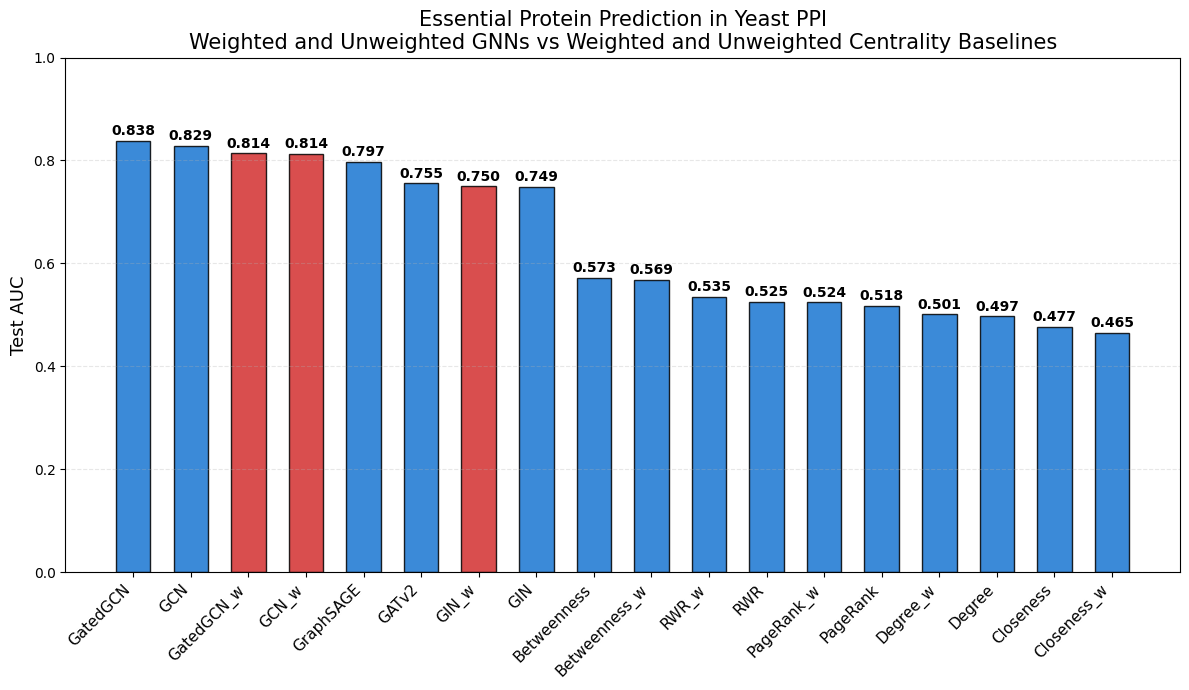

In [95]:
# Combine GNN and centrality AUCs

# Add GNN models
for name, res in results.items():
    all_methods_auc[name] = res["auc"]

# Add weighted centrality baselines
all_methods_auc.update(centrality_auc)

# Sort by AUC descending for better visualization
sorted_methods = dict(sorted(all_methods_auc.items(), key=lambda x: x[1], reverse=True))

# Prepare data for plotting
names = list(sorted_methods.keys())
auc_vals = list(sorted_methods.values())

# Create the plot
plt.figure(figsize=(12, 7))

# Color coding: GNNs in red tones, Centralities in blue tones
colors = []
for name in names:
    if name in results:  # It's a GNN
        colors.append('#d32f2f')  # Deep red for GNNs
    else:  # It's a centrality
        colors.append('#1976d2')  # Deep blue for centralities

bars = plt.bar(names, auc_vals, color=colors, edgecolor='black', alpha=0.85, width=0.6)

# Add AUC values on top of each bar
for bar, val in zip(bars, auc_vals):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.ylabel("Test AUC", fontsize=13)
plt.title("Essential Protein Prediction in Yeast PPI\n"
          "Weighted and Unweighted GNNs vs Weighted and Unweighted Centrality Baselines", fontsize=15)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()